## **Assignment 3 - Main Chain Modelling**
### **Hugo Manuel Alves Henriques e Silva, hugoalv@student.chalmers.se**

#### **How to run:**
`Run the cells below in order. Make sure to have the datasets in the same folder as the notebook.`

### **Question 2**

### **Create the dataset**

In [55]:
import math

def create_data(filename):
    data = {}
    with open(filename) as f:
        line = f.readline()
        counter = 1
        while line:
            line = line.strip()
            line = line.split(' ')
            data[counter] = [line[i] for i in range(0, len(line))]
            line = f.readline()
            counter += 1
            
    for key in data:
        #move \t and everything before it from string of element data[key][0]
        data[key][0] = data[key][0].split('\t')[1]
        #convert string to float
        for i in range(0, len(data[key])):
            data[key][i] = float(data[key][i])

    return data

### **Create a distance matrix and fill it with the distances between the points**

In [56]:
def create_distance_matrix(len):
    dist_matrix = []
    for i in range(0, len):
        row = []
        for j in range(0, len):
            row.append(0)
        dist_matrix.append(row)
    return dist_matrix

def fill_distance_matrix(dist_matrix, data):
    counter1 = 0
    for key1 in data:
        counter2 = 0
        for key2 in data:
            if key1 != key2:
                dist_matrix[counter1][counter2] = round(math.sqrt((data[key1][0] - data[key2][0])**2
                                                    + (data[key1][1] - data[key2][1])**2
                                                    + (data[key1][2] - data[key2][2])**2), 2)
            counter2 += 1
        counter1 += 1

### **Filter the alpha carbons by distance**

Alpha carbons should have a distance of 3.8 Å plus or minus a certain tolerance. The tolerance is the `distance_threshold` variable.

In [57]:
distance_threshold = 0.12

def first_filter_alpha_carbon_data(dist_matrix, data):
    # keep only points that dist 3.8 +- distance_threshold from at least 1 other point
    potential_alpha_C = {}
    for key1 in data:
        for key2 in data:
            if key1 != key2:
                if abs(dist_matrix[key1-1][key2-1] - 3.8) <= distance_threshold:
                    if key1 in potential_alpha_C:
                        potential_alpha_C[key1].append(key2)
                    else:
                        potential_alpha_C[key1] = [key2]
    return potential_alpha_C

### **Calculate the angle between 3 consecutive points**

In [58]:
def calculate_angle_3_points(atom1, atom2, atom3, data):
    vector_1_2 = [data[atom2][0] - data[atom1][0], data[atom2][1] - data[atom1][1], data[atom2][2] - data[atom1][2]]
    vector_1_3 = [data[atom3][0] - data[atom1][0], data[atom3][1] - data[atom1][1], data[atom3][2] - data[atom1][2]]

    norm_vector_1_2 = math.sqrt(vector_1_2[0]**2 + vector_1_2[1]**2 + vector_1_2[2]**2)
    norm_vector_1_3 = math.sqrt(vector_1_3[0]**2 + vector_1_3[1]**2 + vector_1_3[2]**2)

    angle = math.degrees(math.acos((vector_1_2[0]*vector_1_3[0] + vector_1_2[1]*vector_1_3[1] + vector_1_2[2]*vector_1_3[2])/(norm_vector_1_2*norm_vector_1_3)))

    return [angle, atom2, atom3]

### **Remove alpha carbons that only have connections to each other**

In [59]:
def second_filter_alpha_carbons(potential_alpha_C):
    """ 
     remove atoms that only have connections to each other.
    """
    keys_to_remove = []
    for key in potential_alpha_C:
        if len(potential_alpha_C[key]) == 1:
            connection = potential_alpha_C[key][0]
            if len(potential_alpha_C[connection]) == 1:
                # remove key from dict
                keys_to_remove.append(key)
                keys_to_remove.append(connection)

    for key in keys_to_remove:
        if key in potential_alpha_C:
            del potential_alpha_C[key]

### **Create a dictionary with the points, angles and connections**

This dictionary has the following structure:

`{point: [[angle_1, point1, point2], ..., [angle_n, point_x, point_y]}` where the angle is the angle between the vector point-point1 and the 

vector point-point2 for example.

One single point may have several valid angle combinations.

In [60]:
def create_angle_dict(potential_alpha_C, data):
    angles = {}
    for key in potential_alpha_C:
        angles[key] = []
        for i in range(0, len(potential_alpha_C[key])):
            for j in range(i, len(potential_alpha_C[key])):
                if i != j:
                    points_angle = calculate_angle_3_points(key, potential_alpha_C[key][i], potential_alpha_C[key][j], data)
                    angles[key].append(points_angle)
    return angles

### **Filter points by angle**

If the angle between 3 points is less than the threshold, that specific combination is removed from the dictionary.

In [61]:
pseudo_valence_angle_bottom = 60

def first_filter_angles(angles):
    """ 
    removes angle combinations that have an angle that is not in the range of degrees
    """
    for key in angles:
        combinations_to_remove = []
        for combination in angles[key]:
            if (combination[0] < pseudo_valence_angle_bottom):
                combinations_to_remove.append(combination)
        for combination in combinations_to_remove:
            angles[key].remove(combination)


def remove_empty_angles(angles):
    angles_to_remove = []

    for key in angles:
        if angles[key] == []:
            angles_to_remove.append(key)
            continue

    for key in angles_to_remove:
        if key in angles:
            del angles[key]

### **Second filter by angle**

The combinations of each point that contain other points that have been removed are also removed.

In [62]:
def second_filter_angles(angles):
    """ 
        removes angle combinations that have a point that is not in the angles dict
        if an angle has no combinations, remove it from the dict
    """
    pre_angles = []

    while pre_angles != angles:

        angles_to_remove = []

        for key in angles:
            combinations_to_remove = []
            for combination in angles[key]:
                if combination[1] not in angles or combination[2] not in angles:
                    combinations_to_remove.append(combination)
            for combination in combinations_to_remove:
                angles[key].remove(combination)
            if angles[key] == []:
                angles_to_remove.append(key)

        pre_angles = angles.copy()

        for key in angles_to_remove:
            if key in angles:
                del angles[key]

### **Create chain algorithm**

The algorithm takes the angles dictionary, the direction which it is currently building the chain, the points it has visited, the current left

and right chains and the list of all chains obtained so far.

##### **How it works**

Starts with an atom from the angles dictionary. The left and right chain contain already that atom in the first iteration, as does the visited 

list. According to the direction, it will search a combination for that atom and add it to the specific side corresponding to the direction the 

chain is right now being built. The combination has to be a valid one, which means if the left chain is for example `[1, 2, 3]` if the next 

atom that is being added to the chain is 4, the angle between 3->2 and 3->4 has to be valid to obtain `[1, 2, 3, 4]`. Every iteration it tests

going left and right, and if it can't go either way, it returns the chain. If it can go both ways, it will create a new chain for each 
 
direction and add it to the list of chains. It will then call the algorithm again for each of the new chains, and so on.

In [63]:
def createChain(angles, direction, visited, left_chain, right_chain, chains):

    last_left_atom = left_chain[len(left_chain)-1]
    last_right_atom = right_chain[len(right_chain)-1]

    if (len(angles) == len(visited)):
        chains.append(left_chain[::-1] + right_chain[1:])
        return
    
    # when direction is left we want to build the right chain and vice versa
    if direction == "left":
        for combination in angles[last_left_atom]:

            second_to_last_atom = left_chain[len(left_chain)-2]
            need_break = False


            if second_to_last_atom not in combination:
                continue

            first_element_comb = combination[1]
            second_element_comb = combination[2]
            new_element = 0

            if first_element_comb == second_to_last_atom:
                new_element = second_element_comb
            else:
                new_element = first_element_comb

            for i in range(1, 3):
                if combination[i] in visited and second_to_last_atom != combination[i]:
                    need_break = True
            if need_break:
                continue

            left_chain.append(new_element)
            visited.append(new_element)
            createChain(angles, "right", visited, left_chain, right_chain, chains)
            createChain(angles, "left", visited, left_chain, right_chain, chains)
            left_chain = left_chain[0:len(left_chain)-1]
            visited = visited[0:len(visited)-1]
    else:
        for combination in angles[last_right_atom]:
                
                second_to_last_atom = right_chain[len(right_chain)-2]
                need_break = False
    
    
                if second_to_last_atom not in combination:
                    continue
    
                first_element_comb = combination[1]
                second_element_comb = combination[2]
                new_element = 0
    
                if first_element_comb == second_to_last_atom:
                    new_element = second_element_comb
                else:
                    new_element = first_element_comb
    
                for i in range(1, 3):
                    if combination[i] in visited and second_to_last_atom != combination[i]:
                        need_break = True
                if need_break:
                    continue
    
                right_chain.append(new_element)
                visited.append(new_element)
                createChain(angles, "left", visited, left_chain, right_chain, chains)
                createChain(angles, "right", visited, left_chain, right_chain, chains)
                right_chain = right_chain[0:len(right_chain)-1]
                visited = visited[0:len(visited)-1]
            

    chains.append(left_chain[::-1] + right_chain[1:])

### **Complete algorithm**

This function servers as a main function. It builds the chains according to every single previously defined algorithms. It starts building the

chains, and finally returns the chain with the most points. That should correspond to the main alpha carbon chain.

In [64]:
                        
def getChain(filename):

    data = create_data(filename)
    dist_matrix = create_distance_matrix(len(data))
    fill_distance_matrix(dist_matrix, data)

    potential_alpha_C = first_filter_alpha_carbon_data(dist_matrix, data)

    # remove atoms that only have connections to each other.
    second_filter_alpha_carbons(potential_alpha_C)

    angles = create_angle_dict(potential_alpha_C, data)


    # remove combinations that are not in the range of degrees
    first_filter_angles(angles)
    remove_empty_angles(angles)

    second_filter_angles(angles)

    # mash all the angles in a list
    all_alpha_carbons = [key for key in angles]
    # make every element in the list unique
    all_alpha_carbons = list(dict.fromkeys(all_alpha_carbons))
    
    chains = []

    max_len_chains = []
    max_len_chain = []
    max_len = 0

    for atom in angles:

        for combination in angles[atom]:
            left_chain = [atom, combination[1]]
            right_chain = [atom, combination[2]]
            visited = [atom, combination[1], combination[2]]
            createChain(angles, "left", visited.copy(), left_chain.copy(), right_chain.copy(), chains)
            createChain(angles, "right", visited.copy(), left_chain.copy(), right_chain.copy(), chains)

        for chain in chains:
            if len(chain) > max_len:
                max_len = len(chain)
                max_len_chain = chain.copy()
                max_len_chains = []
            elif len(chain) == max_len:
                max_len_chains.append(chain)
        break;

    print(len(list(set(max_len_chain))))

    # delete repeated chains
    chains_to_remove = []
    for i in range(0, len(max_len_chains) - 1):
        if max_len_chains[i] in max_len_chains[i+1:]:
            chains_to_remove.append(max_len_chains[i])

    for chain in chains_to_remove:
        max_len_chains.remove(chain)

    for chain in max_len_chains:
        print(chain)
        return chain, data


chain, data = getChain('data_q2.txt')


41
[260, 297, 322, 320, 307, 255, 234, 165, 152, 110, 163, 143, 202, 223, 205, 189, 217, 243, 294, 301, 266, 256, 237, 203, 177, 160, 117, 83, 69, 63, 39, 19, 4, 3, 16, 27, 54, 72, 70, 44, 36]


### **Plot the chain**

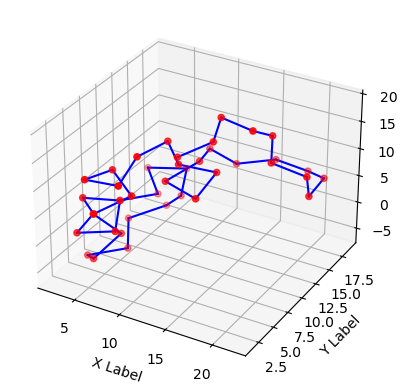

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_chain(chain, data):
    x = []
    y = []
    z = []

    for element in chain:
        x.append(data[element][0])
        y.append(data[element][1])
        z.append(data[element][2])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='r', marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    for i in range(0, len(chain)-1):
        ax.plot([x[i], x[i+1]], [y[i], y[i+1]], [z[i], z[i+1]], c='b')

    plt.show()

plot_chain(chain, data)

### **Obtained chain**

In [66]:
for i in chain:
    print(i)

260
297
322
320
307
255
234
165
152
110
163
143
202
223
205
189
217
243
294
301
266
256
237
203
177
160
117
83
69
63
39
19
4
3
16
27
54
72
70
44
36
